In [64]:
import pandas as pd
import numpy as np
import csv
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import ticker
import statsmodels.api as sm 
import seaborn as sns

1956 0.2006151705550912


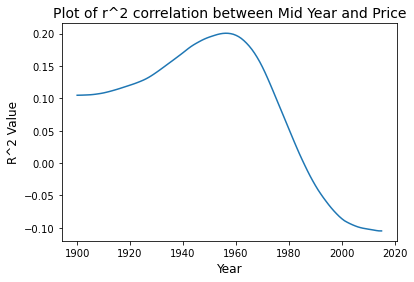

In [168]:
# import house sales data from King Country, WA
df = pd.read_csv('kc_house_data_train.csv', index_col = 0)
pd.set_option('display.max_columns', None) # display all columns

# data cleanup and add features
df.isna().sum(); # there are no blank values

# find outliers
df.bedrooms.sort_values().tail(); # outlier at loc 8597: 33 bedrooms
df.drop(8597, inplace = True) # drop outlier

# add features
# add yard size
(df.sqft_living == df.sqft_above + df.sqft_basement).value_counts(); # check: all True
df['sqft_yard'] = df.sqft_lot - df.sqft_above/df.floors # calculate yard size
# note: cannot calculate yard size of neighbors, missing 'sqft_above15' and 'floors15'
df.sqft_yard.sort_values().head(); # outliers at loc 2392 and 8610: yard sizes -65 and 22
df.drop([2392, 8610], inplace = True) # drop outlier

# log base 10 of price
df['price_log'] = np.log10(df.price) # better than using natural log

# bathrooms
(df.bathrooms[df.bathrooms<0.5]).value_counts(); # found 8 units without even a half bath
df['no_bath'] = np.where(df.bathrooms == 0, 1, 0) # create new variable for has no bathroom
# df.bathrooms = np.where(df.bathrooms == 0, np.nan, df.bathrooms) # replace with np.nan

# basements
(df.sqft_basement[df.sqft_basement==0]).value_counts(); # found many houses without basements
df['has_base'] = np.where(df.sqft_basement == 0, 0, 1) # create new variable for has basement
# df.sqft_basement = np.where(df.sqft_basement == 0, np.nan, df.sqft_basement) # replace with np.nan

# year built vs year renovated
# set year = yr_built, or yr_renovated, whichever is more recent
df['year'] = np.where(df.yr_renovated==0,df.yr_built,df.yr_renovated);
df['reno'] = np.where(df.yr_renovated!=0, 1, 0) # create new variable for has been renovated

# distance from middle of year range
# mid_year = ( df.yr_built.max() - df.yr_built.min() ) / 2 + df.yr_built.min()
r_values = {}
years = range(df.year.min(), df.year.max() + 1)
for year in years:
    df['year_mid'] = np.abs(df['year'] - year)
    r_values[year] = df['year_mid'].corr(df.price)
fig, ax = plt.subplots()
ax.plot(*zip(*sorted(r_values.items())))
ax.set_title('Plot of r^2 correlation between Mid Year and Price', fontdict = {'fontsize': 14})
ax.set_xlabel('Year', fontdict = {'fontsize': 12})
ax.set_ylabel('R^2 Value', fontdict = {'fontsize': 12})
print(max(r_values, key=r_values.get), max(r_values.values()))

# define the pivot year as 1956 and create new feature
mid_year = max(r_values, key=r_values.get)
df['year_mid'] = np.abs(df['year'] - mid_year)

# import dictionary of zips ranked from cheapest median home prices to most expensive
with open('zip_ranks_cheapest_first.csv', newline='', encoding='utf-8-sig') as csv_file:
    my_reader = csv.reader(csv_file)
    zip_dict = {int(row[0]):int(row[1]) for row in my_reader}
df['zip_rank'] = df.zipcode.map(zip_dict)

# find month of sale
df['month'] = pd.DatetimeIndex(df.date).month

# add a polynomial variable
df['grade_2'] = df.grade^2 # grade has a strong correlation

# create interaction variable
df['living_bath'] = df.sqft_living*df.no_bath # having no bathroom makes it hard to live

In [5]:
def set_y_log(sns_obj, ax):
    sns_obj.set(yscale="log")
    ax.get_yaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_yticks([100000, 1000000, 10000000])

In [6]:
def set_x_log(sns_obj, ax):
    sns_obj.set(xscale="log")
    ax.get_xaxis().set_major_formatter(
        ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xticks([100, 1000, 10000, 100000, 1000000])

In [7]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'y', color = u'#1f77b4'):
    ylabel = f'House Price vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    elif ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(ylabel, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel('House Price (Log Scale)', fontdict = {'fontsize': 12})
    plt.savefig(file_name)

In [8]:
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_yard,price_log,no_bath,has_base,year,reno,year_mid,zip_rank,month,grade_2,living_bath
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,7858.000000,5.562293,0,0,1986,0,30,18,10,10,0
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283,4900.000000,5.937016,0,1,1977,0,21,65,8,10,0
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685,9008.000000,6.016197,0,0,1997,0,41,76,8,9,0
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226,12328.000000,6.173186,0,0,1990,0,34,38,3,14,0
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050,4101.000000,5.851870,0,0,2004,0,48,58,7,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400,7940.000000,5.875061,0,1,1958,0,2,57,3,10,0
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013,3350.000000,5.643453,0,0,1948,0,8,71,5,5,0
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403,8826.000000,5.491362,0,0,1953,0,3,45,5,5,0
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028,42319.333333,5.630936,0,1,1971,0,15,26,12,5,0


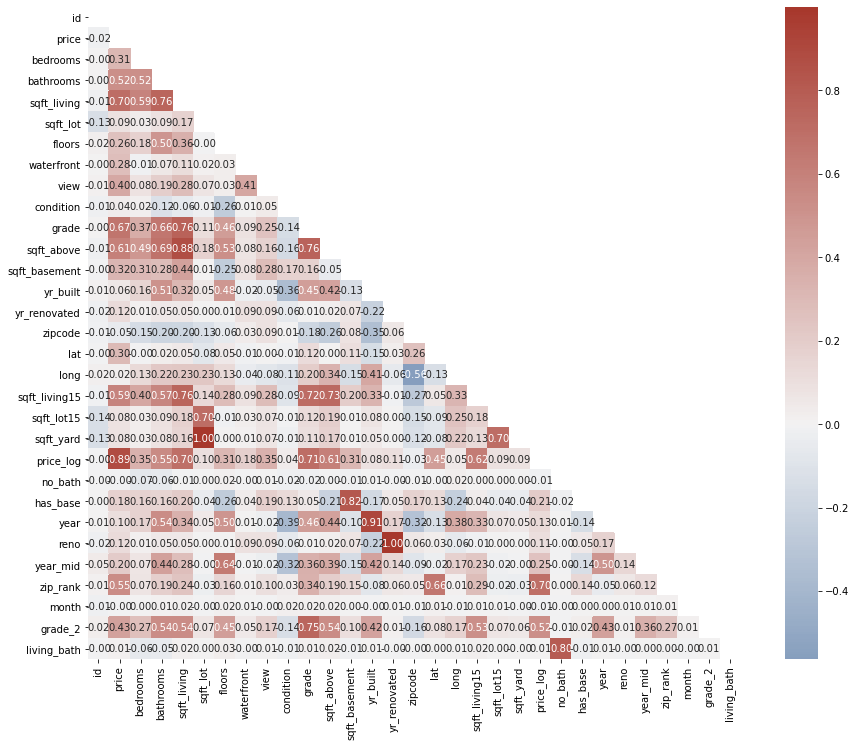

In [9]:
# from https://towardsdev.com/tricks-and-best-practices-from-kaggle-794a5914480f
matrix = df.corr()
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
             fmt='.2f', square=True, cmap=cmap, ax=ax)

Text(0.5, 0.98, 'House Prices Histograms')

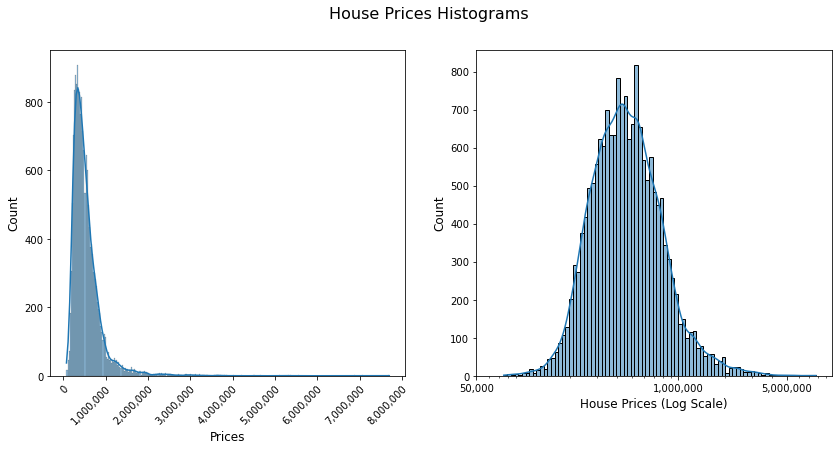

In [10]:
# first look at our dependent variable
fig, ax = plt.subplots(1, 2, figsize = [14,6])
price_plot = sns.histplot(data = df, x = df['price'], kde = True, ax=ax[0])
price_log_plot = sns.histplot(data = df, x = df['price'], kde = True, log_scale = 10, ax=ax[1])
ax[0].get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[0].set_xticks([0, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000])
plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
ax[1].get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].set_xticks([50000, 1000000, 5000000])
ax[0].set_ylabel('Count', fontdict = {'fontsize': 12})
ax[0].set_xlabel('Prices', fontdict = {'fontsize': 12})
ax[1].set_ylabel('Count', fontdict = {'fontsize': 12})
ax[1].set_xlabel('House Prices (Log Scale)', fontdict = {'fontsize': 12})
fig.suptitle('House Prices Histograms', fontsize=16)

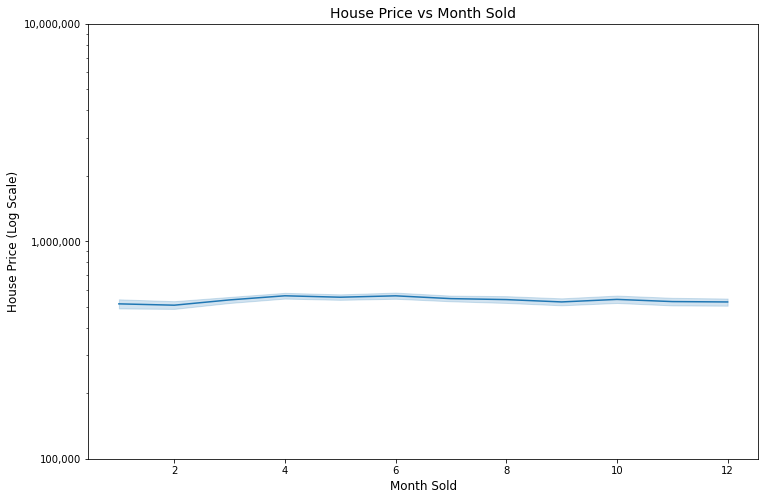

In [11]:
feature_plot(df, df.month, df.price, 'line', 'Month Sold', xlog = 'n', ylog = 'y')

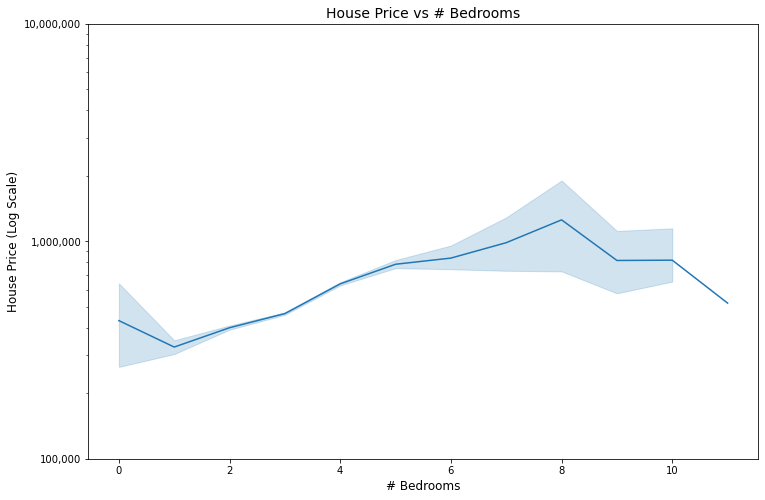

In [12]:
feature_plot(df, df.bedrooms, df.price, 'line', '# Bedrooms', xlog = 'n', ylog = 'y')

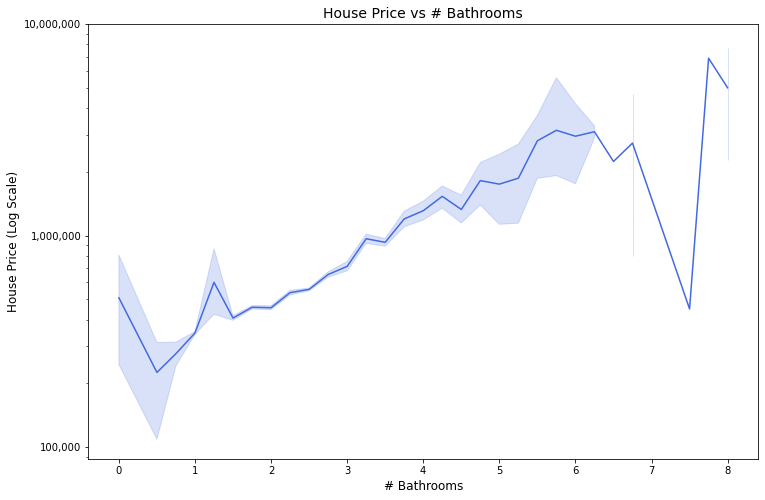

In [13]:
feature_plot(df, df.bathrooms, df.price, 'line', '# Bathrooms',
             xlog = 'n', ylog = 'y', color = 'royalblue')

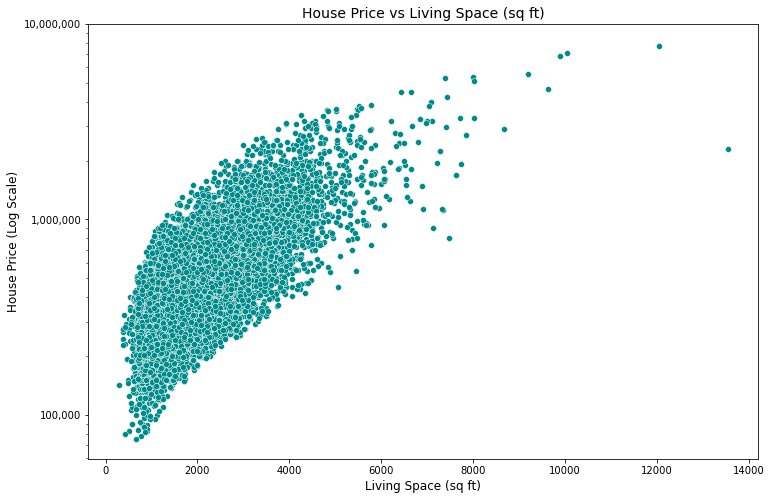

In [14]:
feature_plot(df, df.sqft_living, df.price, 'scatter', 'Living Space (sq ft)',
             xlog = 'n', ylog = 'y', color = 'darkcyan')

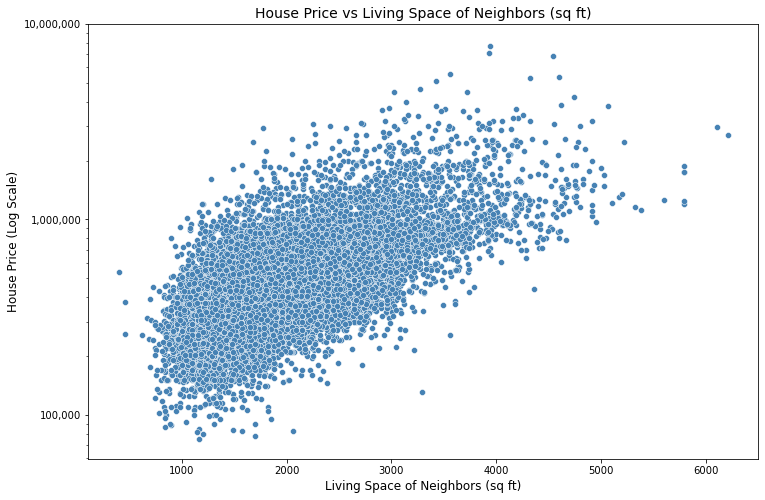

In [15]:
feature_plot(df, df.sqft_living15, df.price, 'scatter', 'Living Space of Neighbors (sq ft)',
             xlog = 'n', ylog = 'y', color = 'steelblue')

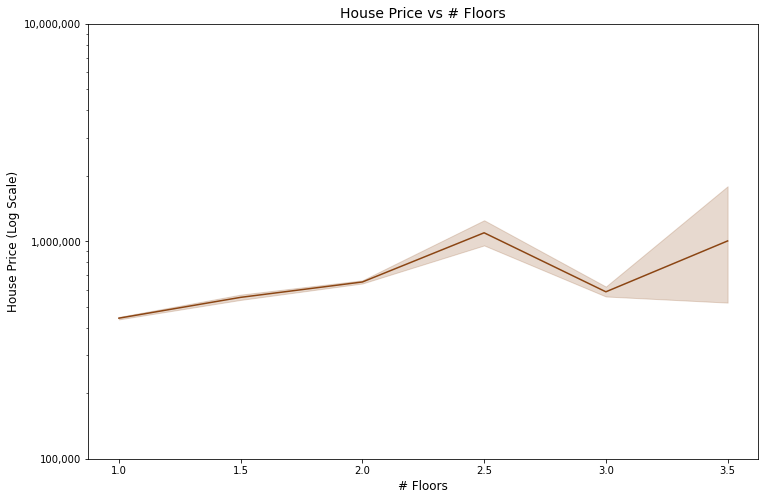

In [16]:
feature_plot(df, df.floors, df.price, 'line', '# Floors',
             xlog = 'n', ylog = 'y', color = 'saddlebrown')

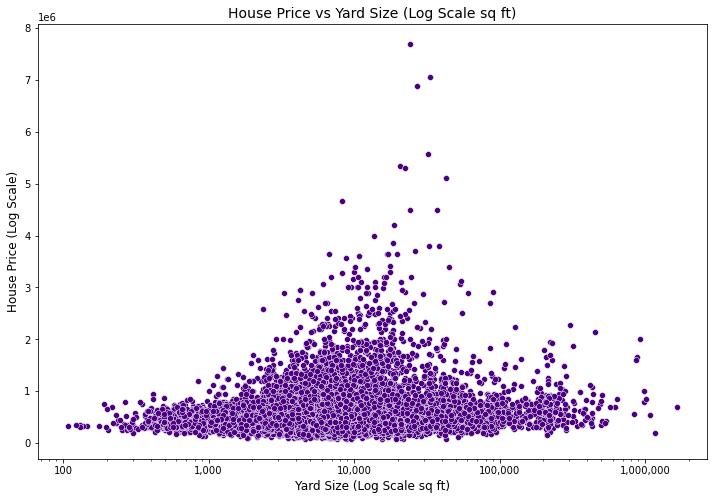

In [17]:
feature_plot(df, df.sqft_yard, df.price, 'scatter', 'Yard Size (Log Scale sq ft)',
             xlog = 'y', ylog = 'y', color = 'indigo')

In [ ]:
feature_plot(df, df.sqft_yard, df.price, 'scatter', 'Yard Size (Log Scale sq ft)',
             xlog = 'y', ylog = 'y', color = 'indigo')

In [269]:
df.sqft_yard.corr(df.price)

0.08224523137257878

In [270]:
np.sqrt(df.sqft_yard).corr(df.price)

0.12689701253888702

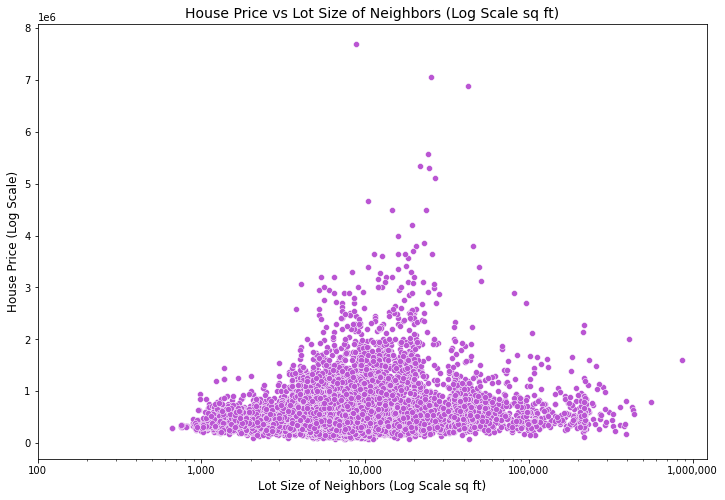

In [18]:
feature_plot(df, df.sqft_lot15, df.price, 'scatter', 'Lot Size of Neighbors (Log Scale sq ft)',
             xlog = 'y', ylog = 'y', color = 'mediumorchid')

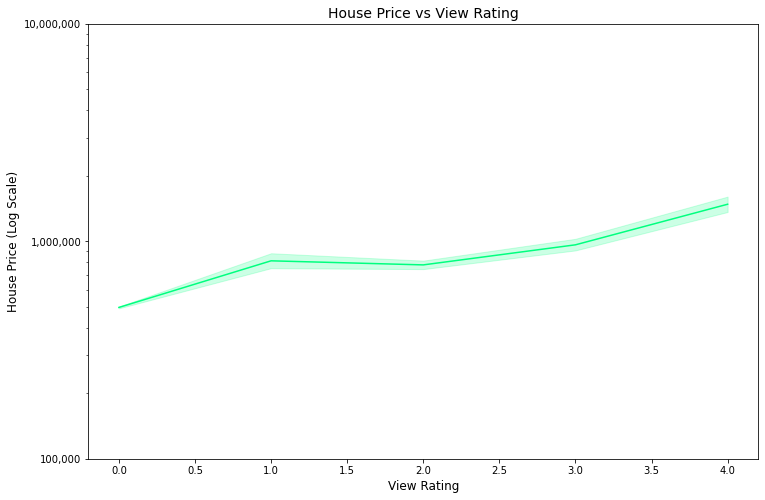

In [19]:
feature_plot(df, df.view, df.price, 'line', 'View Rating',
             xlog = 'x', ylog = 'y', color = 'springgreen')

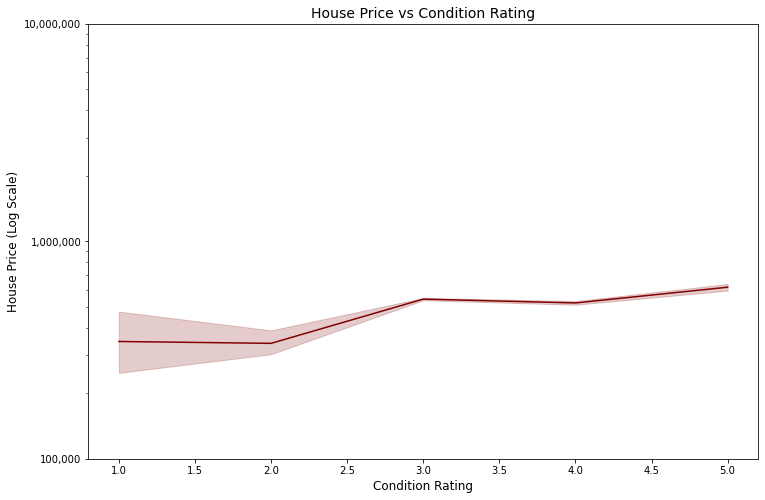

In [20]:
feature_plot(df, df.condition, df.price, 'line', 'Condition Rating',
             xlog = 'x', ylog = 'y', color = 'maroon')

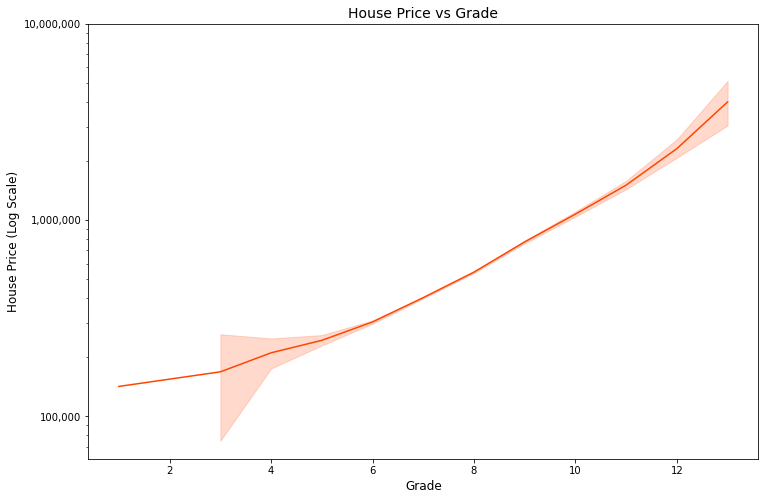

In [21]:
feature_plot(df, df.grade, df.price, 'line', 'Grade',
             xlog = 'x', ylog = 'y', color = 'orangered')

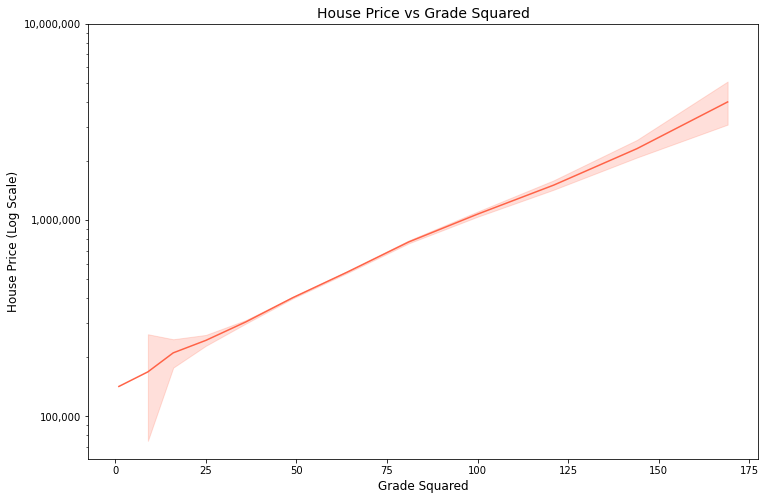

In [22]:
feature_plot(df, df.grade**2, df.price, 'line', 'Grade Squared',
             xlog = 'x', ylog = 'y', color = 'tomato')

There is only one house with grade = 1, considered dropping but shouldn't.

In [23]:
df[df.grade==1]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_yard,price_log,no_bath,has_base,year,reno,year_mid,zip_rank,month,grade_2,living_bath
10067,3980300371,20140926T000000,142000.0,0,0.0,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850,20585.0,5.152288,1,0,1963,0,7,48,9,3,290


Plotting Price vs Basement Size we see a decent correlation.

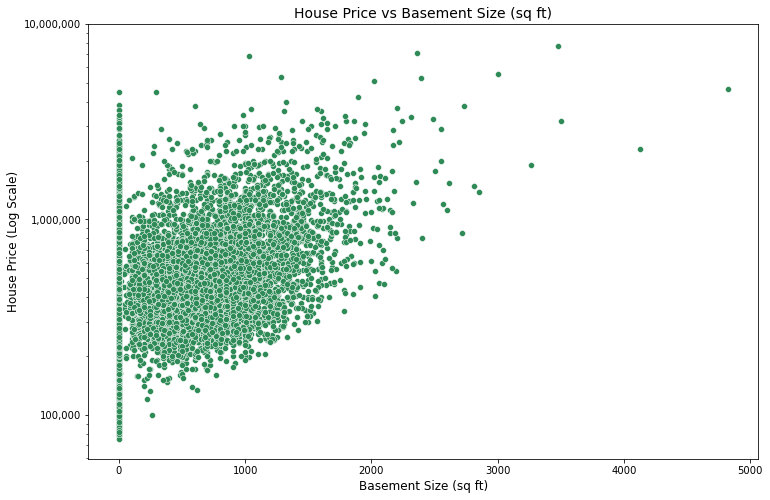

In [24]:
feature_plot(df, df.sqft_basement, df.price, 'scatter', 'Basement Size (sq ft)',
             xlog = 'x', ylog = 'y', color = 'seagreen')

Plotting Price vs Year built or renovated, we see a slight bow in the middle.

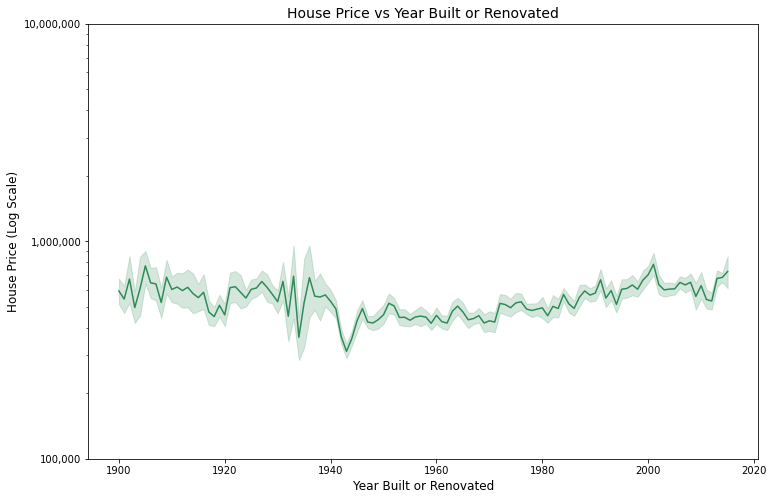

In [25]:
feature_plot(df, df.year, df.price, 'line', 'Year Built or Renovated',
             xlog = 'x', ylog = 'y', color = 'seagreen')

By finding the midpoint, we can engineer a feature that shows distance from the middle, with a clearer linear relationship.

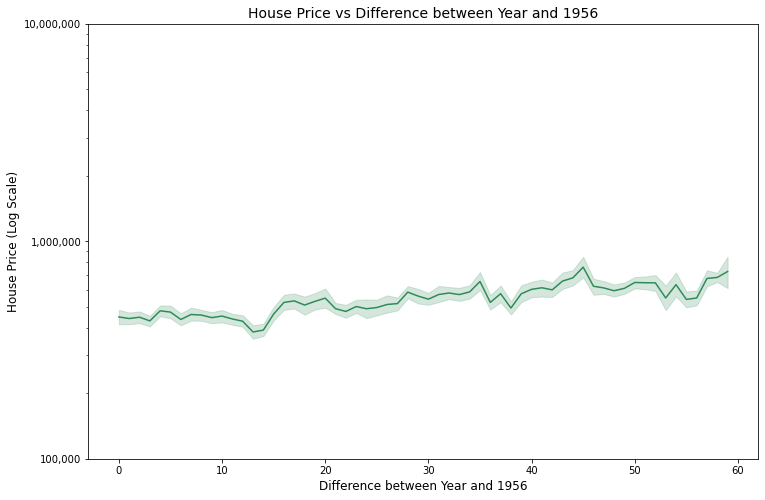

In [26]:
feature_plot(df, df.year_mid, df.price, 'line', 'Difference between Year and 1956',
             xlog = 'x', ylog = 'y', color = 'seagreen')

Because Zip Code is not a continuous variable, plotting it against Price does not yield any useful relationship.

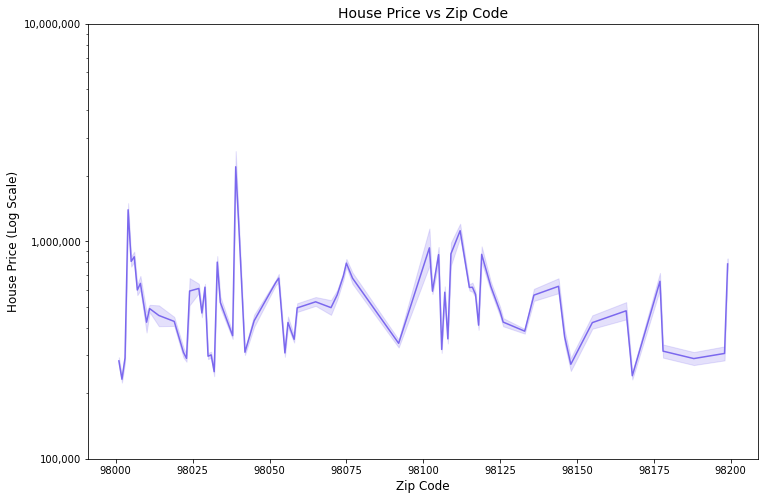

In [77]:
feature_plot(df, df.zipcode, df.price, 'line', 'Zip Code',
             xlog = 'x', ylog = 'y', color = 'mediumslateblue')

However, by finding zip code vs median house pricing data from the US Census and mapping our zip codes to their relative rank, we can find a clearer pattern.

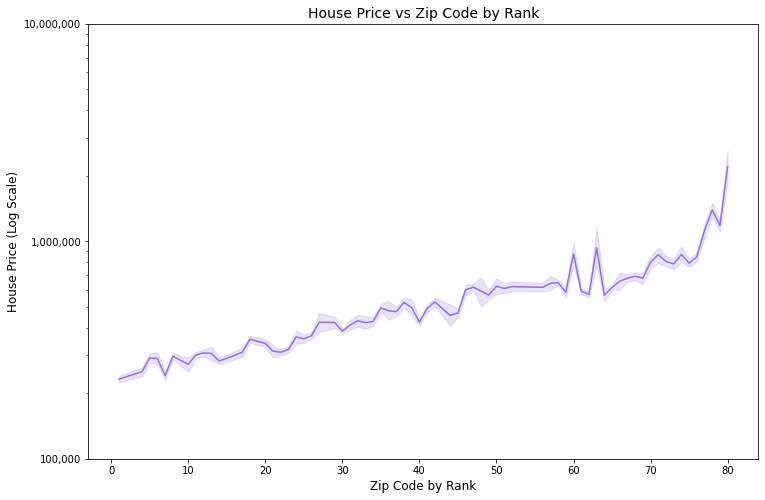

In [85]:
feature_plot(df, df.zip_rank, df.price, 'line', 'Zip Code by Rank',
             xlog = 'x', ylog = 'y', color = 'mediumpurple')

Here's a neat 3D visualization of two important continuous features against House Prices:  
Grade and Living Space (sq ft)

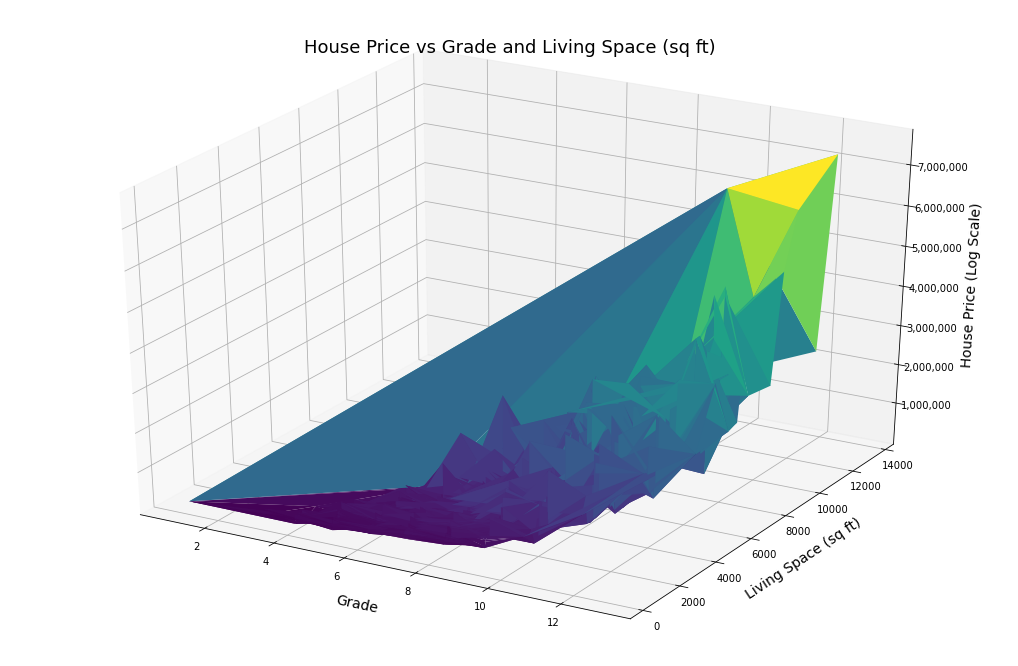

In [28]:
fig = plt.figure(figsize = [18,12])
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(df.grade, df.sqft_living, df.price, cmap=plt.cm.viridis, linewidth=0.2)
# surf = ax.plot_trisurf(df.zipcode, df.sqft_above, df.price, cmap=plt.cm.jet, linewidth=0.1)
ax.get_zaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_title('House Price vs Grade and Living Space (sq ft)', fontdict = {'fontsize': 18})
ax.set_zlabel('House Price (Log Scale)', fontdict = {'fontsize': 14})
ax.set_ylabel('Living Space (sq ft)', fontdict = {'fontsize': 14})
ax.set_xlabel('Grade', fontdict = {'fontsize': 14})
# fig.tight_layout()
ax.tick_params(axis='z', which='major', pad=10)
ax.zaxis.labelpad = 19
ax.yaxis.labelpad = 11
ax.xaxis.labelpad = 13
# fig.colorbar(surf, shrink=0.5, aspect=5, label = 'House Prices')
ax.view_init(30, 300)
plt.savefig('3d_plot.png')
plt.show()

Here is our <i>build_model</i> and <i>dummify</i> functions.  
The <i>dummify</i> function will get dummies on a list of features and concatenate it to a subset of features, and the  <i>build_model</i> function will run tests diving a set of features against House Prices as well as against the Log based 10 of House Prices.

In [264]:
train_target = df.price
train_target_log = df.price_log

def build_model(df_train):
    # run linear regression using House Price as dependent variable
    lm = LinearRegression()
    lm.fit(df_train, train_target)
    price_pred = lm.predict(df_train)
    mse = mean_squared_error(train_target, price_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(train_target, price_pred)
    
    # run linear regression using Log base 10 of House Price as dependent variable
    lm_log = LinearRegression()
    lm_log.fit(df_train, train_target_log)
    price_pred_log = lm_log.predict(df_train)
    log_mse = mean_squared_error(train_target, 10**price_pred_log)
    log_rmse = np.sqrt(log_mse)
    log_r2 = r2_score(train_target_log, price_pred_log)
    
    return {'rmse': rmse, 'log_rmse' : log_rmse}
    
def dummify(features, to_dummy):
    df_subset = df[features]
    
    if len(to_dummy) > 0:
        for feature in to_dummy:
            df_dummy = pd.get_dummies(df[feature])
            try: # check if column already dropped
                df_subset = df_subset.drop(feature, axis = 1)
            except :
#                 print('Column already removed.')
                next
            df_train = pd.concat([df_subset,df_dummy], axis = 1)
    else:
        df_train = df_subset
        
    return df_train

Let's try running a linear regression on all the colums in the original dataset...

In [256]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_yard']
to_dummy = []
build_model(dummify(features, to_dummy))

{'rmse': 204721.48044106393, 'log_rmse': 207062.71234068586}

Already not so bad! But let's some feature engineering tactics to improve this.  
* Remove sqft_lot because it is highly correlated to sqft_living. Instead we added sqft_yard, which is calculated by subtracting sqft_above from sqft_lot and dividing by # of floors. Removed two outliers on this (negative value, tiny value).  
* Add a 'month' feature, based on month of sale.  
* Add a 'grade_2' feature, which is just 'grade' squared, as it is well-correlated to Price.  
* Add a 'no_bath' binary feature to check on which apartments have no bathrooms.  
* Similarly, add a 'has_base' binary feature which are those apartments that have a basement.
* Combine 'yr_built' and 'yr_renovated' to create a 'year' feature, which is equal to whichever of the two features is more recent.  
* Add a 'reno' binary feature which tracks whether the house was renovated at all.  
* Add a 'living_bath' interaction feature which is just living space multiplied by # of bathrooms, which quickly ties out the lack of bathrooms in certain houses.  
* Create dummy variables for 'zipcode' as it is not a continuous feature but rather a categorical feature.

Reminder, with each feature set, we want to run the regression on House Prices, as well as again the Log base 10 of House Prices.

In [265]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'month',
            'grade', 'grade_2', 'condition', 'sqft_basement', 'sqft_living15',
            'sqft_lot15', 'sqft_yard', 'no_bath', 'has_base', 'year', 'reno', 'living_bath',
            'zipcode', 'year_mid'
           ]
to_dummy = ['zipcode']
build_model(dummify(features, to_dummy))

{'rmse': 163070.19936319644, 'log_rmse': 165275.76156423116}

Much better. Trying again, this time we will prune a bit more:
* Remove 'grade' because we already have 'grade_2', removing 'sqft_basement' because we have 'has_base'.  
* Remove 'sqft_yard' because correlationg is low.
* Remove zip code dummies, because we obtained median house pricing data for all zip codes in King County, ranked them from lowest to highest, and mapped the existing 'zipcode' data to this ranking data, as 'zip_rank'.  
* Add 'year_mid', which is the distance between 'year' and the year at which Price was lowest, near the middle of the range of 'year'. We calculated the best correlation by calculating the r squared value for each mid_year in the range of 'year' and finding the max, which was at 1956.  

In [268]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'month',
            'grade_2', 'condition', 'sqft_living15',
            'sqft_lot15', 'has_base', 'reno', 'living_bath', 'zip_rank', 'year_mid']
# to_dummy = ['zipcode']
to_dummy = []
build_model(dummify(features, to_dummy))

{'rmse': 199625.54935844286, 'log_rmse': 213369.47798856}

This was worse than expected. We may have to add some features back in. Playing around with the features, we find that it's best to add all the features back from previous:
* 'grade'
* 'year'
* 'zipcode' dummies
* 

In [267]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'month',
            'grade', 'grade_2', 'condition', 'zip_rank', 'sqft_living15', 'year_mid', 'year',
            'sqft_lot15', 'has_base', 'reno', 'living_bath']
to_dummy = ['zipcode']
# to_dummy = []
build_model(dummify(features, to_dummy))

{'rmse': 163473.77076588865, 'log_rmse': 176173.23665278533}

In [144]:
This is good, but not as good 

{'train_rmse': 185229.8940279408, 'test_rmse': 174934.25586539326}

Another way to test our features is to use the train_test_split function of Scikit-learn to randomly divide up the training data set into a training and a test portion; this allows us to build a model based on the data in the training portion and run it against the data in the test portion.

In [ ]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'month',
            'grade', 'grade_2', 'condition', 'zip_rank', 'sqft_living15', 'year_mid',
            'sqft_lot15', 'has_base', 'year', 'reno', 'living_bath']
tts_target(features, df.price)

In [143]:
def tts_target(features, target):
    df_subset = df[features]
    X_train, X_test, y_train, y_test = train_test_split(features,
                            target, random_state = 1, test_size=0.4)
    
    y_log = np.log10(y_train)
    lm_log = LinearRegression()
    lm_log = lm_log.fit(X_train, y_log)
    log_train_pred  = lm_log.predict(X_train)
    y_train_pred = 10**log_train_pred
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    
    log_test_pred = lm_log.predict(X_test)
    y_test_pred = 10**(log_test_pred)
    
    #evaluate the predictions on the test examples
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    
    return {'train_rmse': train_rmse, 'test_rmse' : test_rmse}

In [72]:
df_subset.corr()[df_subset.corr()>0.7];

In [ ]:
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(df_features)
poly2_columns = poly_2.get_feature_names(df_features.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

In [ ]:
df_test = pd.read_csv('kc_house_data_test_features.csv', index_col = 0)

In [ ]:
df.isna().sum(); # there are no blank values

# add features
# add yard size
df_test['sqft_yard'] = df_test.sqft_lot - df_test.sqft_above/df_test.floors

# bathrooms
df_test['no_bath'] = np.where(df_test.bathrooms == 0, 1, 0) # create new variable for has no bathroom

# basements
df_test['has_base'] = np.where(df_test.sqft_basement == 0, 0, 1) # create new variable for has basement

# year built vs year renovated
df_test['year'] = np.where(df_test.yr_renovated==0,df_test.yr_built,df_test.yr_renovated);
df_test['reno'] = np.where(df_test.yr_renovated!=0, 1, 0) # create new variable for has been renovated

# import dictionary of zips ranked from cheapest median home prices to most expensive
with open('zip_ranks_cheapest_first.csv', newline='', encoding='utf-8-sig') as csv_file:
    my_reader = csv.reader(csv_file)
    zip_dict = {int(row[0]):int(row[1]) for row in my_reader}
df['zip_rank'] = df.zipcode.map(zip_dict)

# add a polynomial variable
df_test['grade_2'] = df_test.grade^2 # grade has a strong correlation

# create interaction variable
df_test['living_bath'] = df_test.sqft_living*df_test.no_bath # having no bathroom makes it hard to live

In [ ]:
df_test_subset = df_test[features]

In [ ]:
df_test_zip_dummy = pd.get_dummies(df_test.zipcode)
df_test_model = pd.concat([df_test_subset.drop('zipcode', axis = 1),df_test_zip_dummy], axis = 1)

In [ ]:
price_pred = lm.predict(df_test_model)
# mse = mean_squared_error(df_target.price, price_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(df_target.price, price_pred)
# print(rmse)
# print(r2)

In [ ]:
price_pred = lm.predict(df_test_model)
price_pred_log = lm_log.predict(df_test_model)

In [ ]:
price_pred.mean()

In [ ]:
10**price_pred_log.mean()

In [ ]:
10**price_pred_log.mbax()

In [ ]:

mse = mean_squared_error(df_target.price, 10**price_pred_log)
rmse = np.sqrt(mse)
r2 = r2_score(df_target.price, price_pred)
print(rmse)
print(r2)

In [ ]:
residuals = df_target.price - price_pred
fig, ax = plt.subplots(3, 1, figsize = [12,12])
sns.residplot(data = [price_pred, df_target.price], x = price_pred, y = df_target.price,
              lowess=True, color='g', ax = ax[0])
sns.distplot(residuals, kde=True, rug=True, ax=ax[1])
sm.qqplot(residuals,line='s', ax=ax[2])
plt.show()

In [ ]:
print (stats.shapiro(residuals))

In [ ]:
pred_10

In [ ]:
residuals = df_target.price - 10**price_pred_log
fig, ax = plt.subplots(3, 1, figsize = [12,12])
# pred_10 = 10**price_pred_log
sns.residplot(data = [price_pred_log, df_target.price], x = price_pred_log, y = df_target.price,
              lowess=True, color='g', ax=ax[0])
sns.distplot(residuals, kde=True, rug=True, ax=ax[1])
sm.qqplot(residuals,line='s', ax=ax[2])
plt.show()

In [ ]:
pickle_out = open(‘features.pickle’,‘wb’)
pickle.dump(list(selected_rfe), pickle_out)
pickle_out.close()